# Import

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample
import seaborn as sns
import numpy as np
import geopandas as gpd
from shapely.geometry import Point

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
MY_PATH = '/content/drive/MyDrive/Brown Spring 2025/EEPS 1340 Machine Learning for the Earth and Environment/EEPS 1340 Project Data/'
#MY_PATH = '/content/drive/MyDrive/EEPS 1340 Project/EEPS 1340 Project Data/'

Mounted at /content/drive


# Initial Analysis

In [ ]:
df = pd.read_csv(MY_PATH+ 'fire_data.csv')

In [ ]:
import folium
from folium.plugins import MarkerCluster

# Folium documentation: https://python-visualization.github.io/folium/latest/getting_started.html

In [ ]:
# #remove missing values - location variables cannot be empty
# df = df.dropna(subset=['Lat_DD', 'Long_DD', 'EstTotalAcres'])

# #locate the center of the map by taking the mean of the latitude and longitude values
# center_lat = df['Lat_DD'].mean()
# center_lon = df['Long_DD'].mean()

# m = folium.Map(location=[center_lat, center_lon], zoom_start=6)
# marker_cluster = MarkerCluster().add_to(m)

# # size function, determine radius using a size value (EstTotalAcres) from the dataframe
# def scale_radius(size):
#   return max(2, size**0.5 / 2)

# # loop goes through relevent rows and generates a marker according to fire size on the appropriate location
# # zoomed out, fires are clustered together
# for idx, row in df.iterrows():
#     radius = scale_radius(row['EstTotalAcres'])
#     popup_text = (f"Fire Name: {row['FireName']}<br>"
#                   f"Size: {row['EstTotalAcres']} acres")
#     folium.CircleMarker(
#         location=[row['Lat_DD'], row['Long_DD']],
#         radius=radius,  # Radius in pixels
#         color='red',
#         fill=True,
#         fill_color='red',
#         fill_opacity=0.6,
#         popup=popup_text
#     ).add_to(marker_cluster)

# m.save("fire_size_map_clustered.html")
# m

In [ ]:
# #source: https://stackoverflow.com/questions/53565979/export-a-folium-map-as-a-png
# !pip install selenium
# import io
# from PIL import Image
# import selenium

# img_data = m._to_png(5)
# img = Image.open(io.BytesIO(img_data))
# #img.save('image.png')

# from google.colab import files
# #files.download('image.png')

## Data Cleaning

Given the outliers we found when plotting, we will filter our df.

In [ ]:
Q1 = df['EstTotalAcres'].quantile(0.25)
Q3 = df['EstTotalAcres'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_nooutliers = df[(df['EstTotalAcres'] >= lower_bound) & (df['EstTotalAcres'] <= upper_bound)]

print(f"Original dataset size: {len(df)}")
print(f"Filtered dataset size: {len(df_nooutliers)}")

Original dataset size: 23490
Filtered dataset size: 19768


After running these initial analysis, we realized there is a data imbalance we should address before training our model.

In [ ]:
len(df_nooutliers[df_nooutliers.HumanOrLightning == 'Lightning'])/len(df_nooutliers)

0.2623431808984217

First, we will undersample!

In [ ]:
df_majority = df_nooutliers[df_nooutliers.HumanOrLightning == 'Human']
df_minority = df_nooutliers[df_nooutliers.HumanOrLightning == 'Lightning']

df_majority_downsampled = resample(df_majority,
                                   replace=False,
                                   n_samples=len(df_minority),
                                   random_state=42)

df_balanced_under = pd.concat([df_majority_downsampled, df_minority])

Then, we will oversample!

In [ ]:
from sklearn.utils import resample

df_minority_upsampled = resample(df_minority,
                                 replace=True,
                                 n_samples=len(df_majority),
                                 random_state=42)

df_balanced = pd.concat([df_majority, df_minority_upsampled])

df_balanced_over = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
len(df_nooutliers), len(df_balanced_under), len(df_balanced_over), len(df_majority), len(df_minority), len(df_majority_downsampled)

(19768, 10372, 29152, 14576, 5186, 5186)

Using the three datasets, we have decided to select these columns to run our models on. We will encode the categorical columns.

In [ ]:
columns_to_keep = [
    'FireYear', 'Area', 'Size_class', 'EstTotalAcres',
    'Protected_Acres', 'HumanOrLightning', 'CauseBy', 'GeneralCause',
    'Lat_DD', 'Long_DD', 'LatLongDD', 'FO_LandOwnType', 'DistrictName',
    'Ign_DateTime', 'Control_DateTime'
]

df_filtered_over = df_balanced_over[columns_to_keep].copy()
df_filtered_under = df_balanced_under[columns_to_keep].copy()
df_filtered_og = df_nooutliers[columns_to_keep].copy()

In [ ]:
size_class_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
df_filtered_over['Size_class_encoded'] = df_filtered_over['Size_class'].map(size_class_mapping)
df_filtered_under['Size_class_encoded'] = df_filtered_under['Size_class'].map(size_class_mapping)
df_filtered_og['Size_class_encoded'] = df_filtered_og['Size_class'].map(size_class_mapping)

In [ ]:
print("Over-sampled:")
print(df_filtered_over.Size_class_encoded.unique(), df_filtered_over.Size_class.unique())

print("\nUnder-sampled:")
print(df_filtered_under.Size_class_encoded.unique(), df_filtered_under.Size_class.unique())

print("\nOriginal:")
print(df_filtered_og.Size_class_encoded.unique(), df_filtered_og.Size_class.unique())

Over-sampled:
[1 2] ['A' 'B']

Under-sampled:
[2 1] ['B' 'A']

Original:
[2 1] ['B' 'A']


In [ ]:
df_filtered_over = pd.get_dummies(
    df_filtered_over,
    columns=['Area', 'FO_LandOwnType', 'DistrictName', 'CauseBy', 'GeneralCause'],
    prefix=['Area', 'LandType', 'DistrictName', 'CauseBy', 'GeneralCause']
)
df_filtered_under = pd.get_dummies(df_filtered_under,
                                   columns=['Area', 'FO_LandOwnType', 'DistrictName', 'CauseBy', 'GeneralCause'],
                                   prefix=['Area', 'LandType', 'DistrictName', 'CauseBy', 'GeneralCause'])
df_filtered_og = pd.get_dummies(df_filtered_og,
                                columns=['Area', 'FO_LandOwnType', 'DistrictName', 'CauseBy', 'GeneralCause'],
                                prefix=['Area', 'LandType', 'DistrictName', 'CauseBy', 'GeneralCause'])

In [ ]:
target_mapping = {'Human': 0, 'Lightning': 1}

df_filtered_over['HumanOrLightning_encoded'] = df_filtered_over['HumanOrLightning'].map(target_mapping)
df_filtered_under['HumanOrLightning_encoded'] = df_filtered_under['HumanOrLightning'].map(target_mapping)
df_filtered_og['HumanOrLightning_encoded'] = df_filtered_og['HumanOrLightning'].map(target_mapping)

In [ ]:
# df_filtered = pd.get_dummies(df_filtered, columns=['FO_LandOwnType'], prefix='LandType')
# df_filtered = pd.get_dummies(df_filtered, columns=['DistrictName'], prefix='DistrictName')
# df_filtered = pd.get_dummies(df_filtered, columns=['CauseBy'], prefix='CauseBy')
# df_filtered = pd.get_dummies(df_filtered, columns=['GeneralCause'], prefix='GeneralCause')

In [ ]:
#Time Columns - Soph
#Ignition Time - convert to month
from datetime import datetime #import date time
from datetime import date #import date
df_filtered_og['Ign_DateTime'] = pd.to_datetime(df_filtered_og['Ign_DateTime'])
df_filtered_over['Ign_DateTime'] = pd.to_datetime(df_filtered_over['Ign_DateTime'])
df_filtered_under['Ign_DateTime'] = pd.to_datetime(df_filtered_under['Ign_DateTime'])
#convert the column to a date time category
df_filtered_og['Ign_Month'] = df_filtered_og['Ign_DateTime'].dt.month
df_filtered_over['Ign_Month'] = df_filtered_over['Ign_DateTime'].dt.month
df_filtered_under['Ign_Month'] = df_filtered_under['Ign_DateTime'].dt.month
#convert the columns to extract only the months (which are floats)
print(df_filtered_over['Ign_Month'])
#print the column

0         7.0
1         7.0
2         6.0
3         4.0
4         5.0
         ... 
29147     7.0
29148    10.0
29149     9.0
29150     8.0
29151     3.0
Name: Ign_Month, Length: 29152, dtype: float64


In [ ]:
#Ignition - Control Time - convert to minutes
df_filtered_og['Control_DateTime'] = pd.to_datetime(df_filtered_og['Control_DateTime'])
df_filtered_under['Control_DateTime'] = pd.to_datetime(df_filtered_under['Control_DateTime'])
df_filtered_over['Control_DateTime'] = pd.to_datetime(df_filtered_over['Control_DateTime'])
#convert column to a date time category
df_filtered_og['Time_Difference'] = df_filtered_og['Control_DateTime'] - df_filtered_og['Ign_DateTime']
df_filtered_under['Time_Difference'] = df_filtered_under['Control_DateTime'] - df_filtered_under['Ign_DateTime']
df_filtered_over['Time_Difference'] = df_filtered_over['Control_DateTime'] - df_filtered_over['Ign_DateTime']
#find the time difference between ignition time and control time
df_filtered_og['Control_Minutes'] = df_filtered_og['Time_Difference'].dt.total_seconds()/60
df_filtered_under['Control_Minutes'] = df_filtered_under['Time_Difference'].dt.total_seconds()/60
df_filtered_over['Control_Minutes'] = df_filtered_over['Time_Difference'].dt.total_seconds()/60
#convert the time difference to seconds
print(df_filtered_og['Control_Minutes'])
print(df_filtered_under['Control_Minutes'])
print(df_filtered_over['Control_Minutes'])
#print the column

2        1790.0
4          50.0
5        2895.0
6           6.0
7         330.0
          ...  
23484      45.0
23485     358.0
23486      54.0
23488      92.0
23489      67.0
Name: Control_Minutes, Length: 19768, dtype: float64
20334    29109.0
15694    15000.0
5481        23.0
11182        6.0
19214     5385.0
          ...   
23469      948.0
23470     4702.0
23472     4380.0
23474     1025.0
23489       67.0
Name: Control_Minutes, Length: 10372, dtype: float64
0            0.0
1         1123.0
2         4218.0
3           75.0
4        45930.0
          ...   
29147      361.0
29148       14.0
29149      433.0
29150     1800.0
29151     1621.0
Name: Control_Minutes, Length: 29152, dtype: float64


In [ ]:
df_filtered_og['Time_Difference'] = pd.to_timedelta(df_filtered_og['Time_Difference'])
df_filtered_under['Time_Difference'] = pd.to_timedelta(df_filtered_under['Time_Difference'])
df_filtered_over['Time_Difference'] = pd.to_timedelta(df_filtered_over['Time_Difference'])
df_filtered_og['Time_Difference'] = df_filtered_og['Time_Difference'].dt.total_seconds() / 60
df_filtered_under['Time_Difference'] = df_filtered_under['Time_Difference'].dt.total_seconds() / 60
df_filtered_over['Time_Difference'] = df_filtered_over['Time_Difference'].dt.total_seconds()

In [ ]:
print("Original:")
print(df_filtered_og.isna().sum().sum())
print(np.round(df_filtered_og.isna().sum().sum()*100/len(df_filtered_og), 2))

print("\nUnder-sampled:")
print(df_filtered_under.isna().sum().sum())
print(np.round(df_filtered_under.isna().sum().sum()*100/len(df_filtered_under), 2))

print("\nOver-sampled:")
print(df_filtered_over.isna().sum().sum())
print(np.round(df_filtered_over.isna().sum().sum()*100/len(df_filtered_over), 2))

Original:
43
0.22

Under-sampled:
10
0.1

Over-sampled:
27
0.09


In [ ]:
df_filtered_nan_og = df_filtered_og.dropna()
df_filtered_nan_under = df_filtered_under.dropna()
df_filtered_nan_over = df_filtered_over.dropna()

y_og = df_filtered_nan_og['EstTotalAcres']
X_og = df_filtered_nan_og.drop(columns=[
    'EstTotalAcres',        #target variable for regression analysis
    'Protected_Acres',      #removing in case of data leakage
    'Size_class_encoded',   # removed as size is typically based on outcome size (acres)
    'LandType_ERROR: #N/A',
    'Time_Difference',      # not known at point of estimation
    'Control_Minutes',
    'HumanOrLightning',
    'LatLongDD',            # duplicate of Lat + Long
    'Ign_DateTime',         # raw datetime
    'Control_DateTime',     # raw datetime
    'Size_class',
    'CauseBy_Fisherman',
    'CauseBy_Hiker',
    'CauseBy_Hunter',
    'CauseBy_Lightning',
    'CauseBy_Marijuana Grower',
    'CauseBy_Motorist',
    'CauseBy_Other Forest Mgt. Worker',
    'CauseBy_Other-Landowner Related',
    'CauseBy_Other-Public',
    'CauseBy_Public Utility',
    'CauseBy_Rancher-Farmer',
    'CauseBy_Recreationist',
    'CauseBy_Ruralist-Non-Paying',
    'CauseBy_Ruralist-Paying',
    'CauseBy_Timber Harvest Worker',
    'CauseBy_Transient',
    'GeneralCause_Lightning'
])
y_under = df_filtered_nan_under['EstTotalAcres']
X_under = df_filtered_nan_under.drop(columns=[
    'EstTotalAcres',        #target variable for regression analysis
    'Protected_Acres',      #removing in case of data leakage
    'Size_class_encoded',   # removed as size is typically based on outcome size (acres)
    'LandType_ERROR: #N/A',
    'Time_Difference',      # not known at point of estimation
    'Control_Minutes',
    'HumanOrLightning',
    'LatLongDD',            # duplicate of Lat + Long
    'Ign_DateTime',         # raw datetime
    'Control_DateTime',     # raw datetime
    'Size_class',
    'CauseBy_Fisherman',
    'CauseBy_Hiker',
    'CauseBy_Hunter',
    'CauseBy_Lightning',
    'CauseBy_Marijuana Grower',
    'CauseBy_Motorist',
    'CauseBy_Other Forest Mgt. Worker',
    'CauseBy_Other-Landowner Related',
    'CauseBy_Other-Public',
    'CauseBy_Public Utility',
    'CauseBy_Rancher-Farmer',
    'CauseBy_Recreationist',
    'CauseBy_Ruralist-Non-Paying',
    'CauseBy_Ruralist-Paying',
    'CauseBy_Timber Harvest Worker',
    'CauseBy_Transient',
    'GeneralCause_Lightning'

])
y_over = df_filtered_nan_over['EstTotalAcres']
X_over = df_filtered_nan_over.drop(columns=[
    'EstTotalAcres',        #target variable for regression analysis
    'Protected_Acres',      #removing in case of data leakage
    'Size_class_encoded',   # removed as size is typically based on outcome size (acres)
    'LandType_ERROR: #N/A',
    'Time_Difference',      # not known at point of estimation
    'Control_Minutes',
    'HumanOrLightning',
    'LatLongDD',            # duplicate of Lat + Long
    'Ign_DateTime',         # raw datetime
    'Control_DateTime',     # raw datetime
    'Size_class',
    'CauseBy_Fisherman',
    'CauseBy_Hiker',
    'CauseBy_Hunter',
    'CauseBy_Lightning',
    'CauseBy_Marijuana Grower',
    'CauseBy_Motorist',
    'CauseBy_Other Forest Mgt. Worker',
    'CauseBy_Other-Landowner Related',
    'CauseBy_Other-Public',
    'CauseBy_Public Utility',
    'CauseBy_Rancher-Farmer',
    'CauseBy_Recreationist',
    'CauseBy_Ruralist-Non-Paying',
    'CauseBy_Ruralist-Paying',
    'CauseBy_Timber Harvest Worker',
    'CauseBy_Transient',
    'GeneralCause_Lightning'
])
y_over = df_filtered_nan_over['EstTotalAcres']

In [ ]:
# train-test split at 10% test and 90% train
from sklearn.model_selection import train_test_split

X_train_og, X_test_og, y_train_og, y_test_og = train_test_split(X_og, y_og, test_size=0.1, random_state=2025)
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_under, y_under, test_size=0.1, random_state=2025)
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(X_over, y_over, test_size=0.1, random_state=2025)

#Baseline Regression Model - Linear Regression

The goal of the baseline regression model is to establish a benchmark performance level. In this case it will be a simple model that we will use to compare more complex models to.
We will begin with a Linear Regression.

In [ ]:
# Imports
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

## Original Dataset

In [ ]:
# initialization
lr_og = LinearRegression()

# train on og dataset
lr_og.fit(X_train_og, y_train_og)

# make prediction based on test data
y_pred_og = lr_og.predict(X_test_og)

# evaluation
mse_og = mean_squared_error(y_test_og, y_pred_og)
rmse_og = np.sqrt(mse_og) # Calculate RMSE
r2_og = r2_score(y_test_og, y_pred_og)

print("Original Data Baseline Results:")
print(f"Mean Squared Error (MSE): {mse_og}")
print(f"Root Mean Squared Error (RMSE): {rmse_og}")
print(f"R-squared (R2): {r2_og}")

Original Data Baseline Results:
Mean Squared Error (MSE): 0.05126235001369684
Root Mean Squared Error (RMSE): 0.22641190342757345
R-squared (R2): 0.028333995685946634


##Undersampled Data

In [ ]:
# initialization
lr_under = LinearRegression()

# train model on undersampled data
lr_under.fit(X_train_under, y_train_under)

# make predications based on test data
y_pred_under = lr_under.predict(X_test_under)

#evaluation
mse_under = mean_squared_error(y_test_under, y_pred_under)
rmse_under = np.sqrt(mse_under) # Calculate RMSE
r2_under = r2_score(y_test_under, y_pred_under)

print("Undersampled Data Baseline Results:")
print(f"Mean Squared Error (MSE): {mse_under}")
print(f"Root Mean Squared Error (RMSE): {rmse_under}")
print(f"R-squared (R2): {r2_under}")

Undersampled Data Baseline Results:
Mean Squared Error (MSE): 0.05605859759665244
Root Mean Squared Error (RMSE): 0.23676696897298077
R-squared (R2): 0.008457971719345592


## Oversampled Data

In [ ]:
# initialization
lr_over = LinearRegression()

# train the model on oversampled data
lr_over.fit(X_train_over, y_train_over)

# make predictions based on test data
y_pred_over = lr_over.predict(X_test_over)

# evaluation
mse_over = mean_squared_error(y_test_over, y_pred_over)
rmse_over = np.sqrt(mse_over) # Calculate RMSE
r2_over = r2_score(y_test_over, y_pred_over)

print("Oversampled Data Baseline Results:")
print(f"Mean Squared Error (MSE): {mse_over}")
print(f"Root Mean Squared Error (RMSE): {rmse_over}")
print(f"R-squared (R2): {r2_over}")

Oversampled Data Baseline Results:
Mean Squared Error (MSE): 0.04822886996872437
Root Mean Squared Error (RMSE): 0.2196107237106703
R-squared (R2): 0.02039766159828582


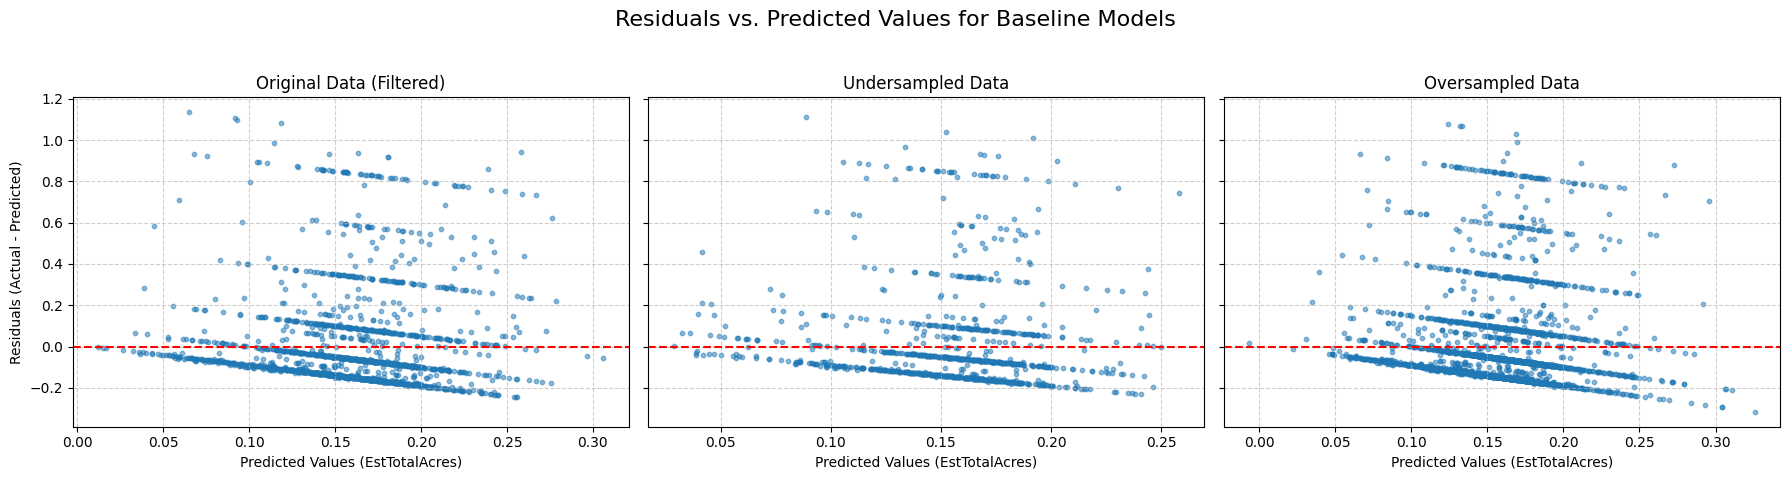

In [ ]:
import matplotlib.pyplot as plt

# calculate residuals for each dataset
residuals_og = y_test_og - y_pred_og
residuals_under = y_test_under - y_pred_under
residuals_over = y_test_over - y_pred_over

# create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
fig.suptitle('Residuals vs. Predicted Values for Baseline Models', fontsize=16)

# plot for Original Data
axes[0].scatter(y_pred_og, residuals_og, alpha=0.5, s=10) # Smaller points with alpha
axes[0].axhline(y=0, color='red', linestyle='--')
axes[0].set_title('Original Data (Filtered)')
axes[0].set_xlabel('Predicted Values (EstTotalAcres)')
axes[0].set_ylabel('Residuals (Actual - Predicted)')
axes[0].grid(True, linestyle='--', alpha=0.6)

# plot for Undersampled Data
axes[1].scatter(y_pred_under, residuals_under, alpha=0.5, s=10)
axes[1].axhline(y=0, color='red', linestyle='--')
axes[1].set_title('Undersampled Data')
axes[1].set_xlabel('Predicted Values (EstTotalAcres)')
# axes[1].set_ylabel('Residuals') # Y-label is shared
axes[1].grid(True, linestyle='--', alpha=0.6)

# plot for Oversampled Data
axes[2].scatter(y_pred_over, residuals_over, alpha=0.5, s=10)
axes[2].axhline(y=0, color='red', linestyle='--')
axes[2].set_title('Oversampled Data')
axes[2].set_xlabel('Predicted Values (EstTotalAcres)')
# axes[2].set_ylabel('Residuals') # Y-label is shared
axes[2].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()


The baseline Linear Regression model performs poorly on this task. The performance across all datasets was similarly poor. The lowest error was from the oversample data, followed by the original. The model has little predictive power for the target variable, EstTotalAcres. This illustrates the complexity of predicting wildfire size and likely requires more sophisticated approaches that a linear combination of features.

The residual plot show that a Linear Regression model is not a good fit for the data. The non-random patterns show that linear assumptions are violated and the model does not capture the underlying relationships between the features and target.

#Random Forest Regression


In [ ]:
# imports
from sklearn.ensemble import RandomForestRegressor

##Original Dataset

In [ ]:
# initialization
rf_og = RandomForestRegressor(n_estimators=100, random_state=2025, n_jobs=-1)

# train on original data
rf_og.fit(X_train_og, y_train_og)

# make prediction on og data
y_pred_rf_og = rf_og.predict(X_test_og)

# evaluation
mse_rf_og = mean_squared_error(y_test_og, y_pred_rf_og)
rmse_rf_og = np.sqrt(mse_rf_og)
r2_rf_og = r2_score(y_test_og, y_pred_rf_og)

print("Random Forest Original Data Results:")
print(f"Mean Squared Error (MSE): {mse_rf_og}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf_og}")
print(f"R-squared (R2): {r2_rf_og}")

Random Forest Original Data Results:
Mean Squared Error (MSE): 0.05272091635404172
Root Mean Squared Error (RMSE): 0.22961035768022686
R-squared (R2): 0.0006872075934926114


In [ ]:
# initialization
rf_under = RandomForestRegressor(n_estimators=100, random_state=2025, n_jobs=-1)

# train on undersampled data
rf_under.fit(X_train_under, y_train_under)

# make predictions on undersampled data
y_pred_rf_under = rf_under.predict(X_test_under)

# evaluation
mse_rf_under = mean_squared_error(y_test_under, y_pred_rf_under)
rmse_rf_under = np.sqrt(mse_rf_under)
r2_rf_under = r2_score(y_test_under, y_pred_rf_under)

print("Random Forest Undersampled Data Results:")
print(f"Mean Squared Error (MSE): {mse_rf_under}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf_under}")
print(f"R-squared (R2): {r2_rf_under}")

Random Forest Undersampled Data Results:
Mean Squared Error (MSE): 0.057080588177340776
Root Mean Squared Error (RMSE): 0.23891544147949242
R-squared (R2): -0.009618588464171296


In [ ]:
# initialization
rf_over = RandomForestRegressor(n_estimators=100, random_state=2025, n_jobs=-1)

#train on oversampled data
rf_over.fit(X_train_over, y_train_over)

#make predictions on oversampled data
y_pred_rf_over = rf_over.predict(X_test_over)

# evaluation
mse_rf_over = mean_squared_error(y_test_over, y_pred_rf_over)
rmse_rf_over = np.sqrt(mse_rf_over)
r2_rf_over = r2_score(y_test_over, y_pred_rf_over)

print("Random Forest Oversampled Data Results:")
print(f"Mean Squared Error (MSE): {mse_rf_over}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf_over}")
print(f"R-squared (R2): {r2_rf_over}")

Random Forest Oversampled Data Results:
Mean Squared Error (MSE): 0.030629719183056004
Root Mean Squared Error (RMSE): 0.17501348286076707
R-squared (R2): 0.3778634134333395


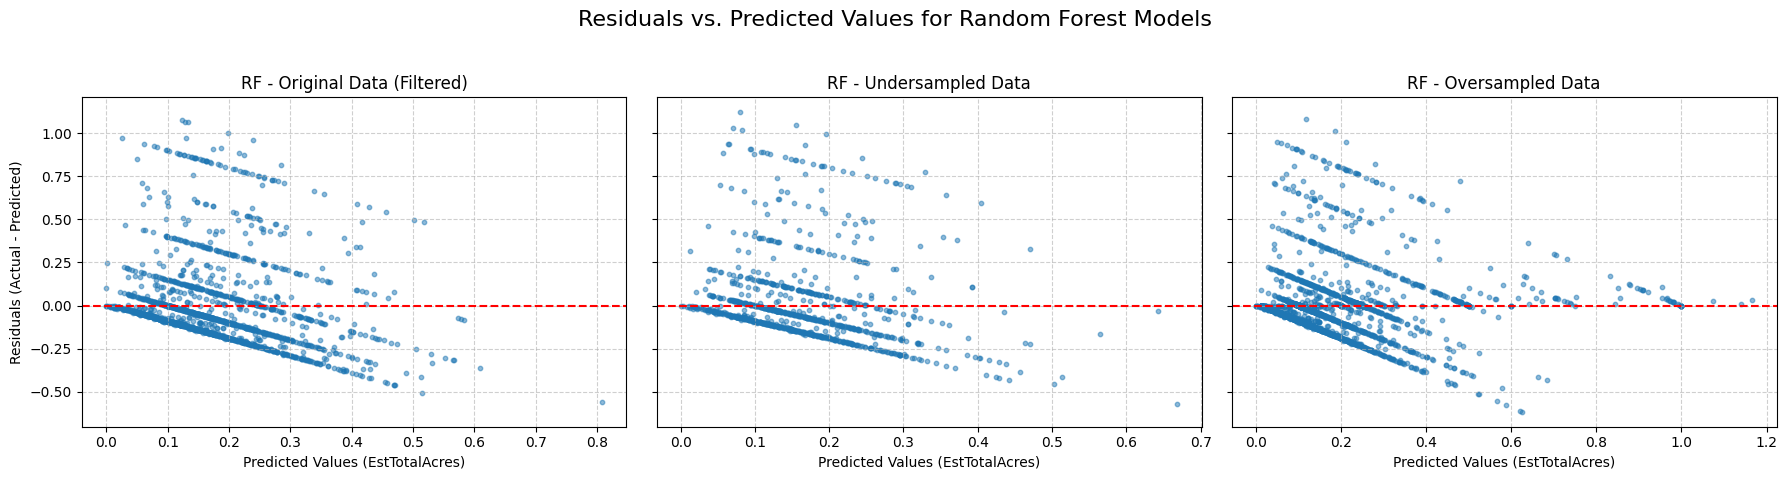

In [ ]:
# Random Forest Residuals

# calculate residuals
residuals_rf_og = y_test_og - y_pred_rf_og
residuals_rf_under = y_test_under - y_pred_rf_under
residuals_rf_over = y_test_over - y_pred_rf_over

# create subplots
fig_rf, axes_rf = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
fig_rf.suptitle('Residuals vs. Predicted Values for Random Forest Models', fontsize=16)

# plot for Original Data
axes_rf[0].scatter(y_pred_rf_og, residuals_rf_og, alpha=0.5, s=10)
axes_rf[0].axhline(y=0, color='red', linestyle='--')
axes_rf[0].set_title('RF - Original Data (Filtered)')
axes_rf[0].set_xlabel('Predicted Values (EstTotalAcres)')
axes_rf[0].set_ylabel('Residuals (Actual - Predicted)')
axes_rf[0].grid(True, linestyle='--', alpha=0.6)

# plot for Undersampled Data
axes_rf[1].scatter(y_pred_rf_under, residuals_rf_under, alpha=0.5, s=10)
axes_rf[1].axhline(y=0, color='red', linestyle='--')
axes_rf[1].set_title('RF - Undersampled Data')
axes_rf[1].set_xlabel('Predicted Values (EstTotalAcres)')
axes_rf[1].grid(True, linestyle='--', alpha=0.6)

# plot for Oversampled Data
axes_rf[2].scatter(y_pred_rf_over, residuals_rf_over, alpha=0.5, s=10)
axes_rf[2].axhline(y=0, color='red', linestyle='--')
axes_rf[2].set_title('RF - Oversampled Data')
axes_rf[2].set_xlabel('Predicted Values (EstTotalAcres)')
axes_rf[2].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

The Random Forest regression model performed worse than the baseline linear regression model on both the original data and the undersampled data. This may be have occured if the default Random Forest parameters led to overfitting on the training set. Another reason could be even Random Forest is unable to capute the relationships.

On the oversampled data, Random Forest shows a significant improvement. On this data, the model can predict about 38% of the variance in the size of the small fires, compared to 2% from the Linear Regression baseline. RSME also decreased from 0.220 to 0.175 acres, meaning predictions are closer to the actual values, on average. Oversampling likely provided the algorithm with enough examples to learn more complex patterns and interactions; something that it was unable to do with the original or undersampled data.

##Hyperparameter Tuning

In [ ]:
# imports
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [ ]:
# define the parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(low=100, high=500), # Number of trees
    'max_depth': [None] + list(randint(low=10, high=50).rvs(5)), # max depth of trees (None means full depth) + 5 random values between 10 and 50
    'min_samples_split': randint(low=2, high=20), # min samples to split a node
    'min_samples_leaf': randint(low=1, high=20),  # min samples at a leaf node
    'max_features': ['sqrt', 'log2', 0.3, 0.5, 0.7] # features to consider at each split
}

In [ ]:
rf_base = RandomForestRegressor(random_state=2025, n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=50,  # Try 50 different combinations
    cv=3,       # Use 3-fold cross-validation
    scoring='r2',
    verbose=2,
    random_state=2025,
    n_jobs=-1  # Use all cores for CV folds if possible
)

In [ ]:
print("Starting Randomized Search CV for Random Forest on oversampled data...")
random_search.fit(X_train_over, y_train_over)
print("Randomized Search CV complete.")

Starting Randomized Search CV for Random Forest on oversampled data...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Randomized Search CV complete.


In [ ]:
# best parameters and score
best_params = random_search.best_params_
best_score = random_search.best_score_

# train final model using best parameters
rf_tuned = RandomForestRegressor(**best_params, random_state=2025, n_jobs=-1)
rf_tuned.fit(X_train_over, y_train_over)

# evaluation
y_pred_rf_tuned = rf_tuned.predict(X_test_over)

mse_rf_tuned = mean_squared_error(y_test_over, y_pred_rf_tuned)
rmse_rf_tuned = np.sqrt(mse_rf_tuned)
r2_rf_tuned = r2_score(y_test_over, y_pred_rf_tuned)

print("Tuned Random Forest (Oversampled Data) Test Set Results:")
print(f"Mean Squared Error (MSE): {mse_rf_tuned}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf_tuned}")
print(f"R-squared (R2): {r2_rf_tuned}")

# comparison
print(f"\nComparison with Untuned RF on Oversampled Data:")
print(f"  Untuned R2: {r2_rf_over:.4f}")
print(f"  Tuned R2:   {r2_rf_tuned:.4f}")

Tuned Random Forest (Oversampled Data) Test Set Results:
Mean Squared Error (MSE): 0.029921672895038727
Root Mean Squared Error (RMSE): 0.1729788220998129
R-squared (R2): 0.3922449197777379

Comparison with Untuned RF on Oversampled Data:
  Untuned R2: 0.3779
  Tuned R2:   0.3922


Hyperparamter tuning did not yeild a meaningful improvment in performance over the default paramters.

# LightGBM
While not covered in class, LightGBM is a good choice as it is highly effective on tabular data. It is also well-suited for large datasets. From now on, we will work with only the oversampled data.

In [ ]:
# imports
import lightgbm as lgb

In [ ]:
# initialization
lgbm = lgb.LGBMRegressor(random_state=2025, n_jobs=-1)

#train  the  model on oversampled training daa
lgbm.fit(X_train_over, y_train_over)

# make prediction on test data
y_pred_lgbm = lgbm.predict(X_test_over)

# evaluation
mse_lgbm = mean_squared_error(y_test_over, y_pred_lgbm)
rmse_lgbm = np.sqrt(mse_lgbm)
r2_lgbm = r2_score(y_test_over, y_pred_lgbm)

print("\n--- LightGBM (Oversampled Data) Results ---")
print(f"Mean Squared Error (MSE): {mse_lgbm}")
print(f"Root Mean Squared Error (RMSE): {rmse_lgbm}")
print(f"R-squared (R2): {r2_lgbm}")

# comparision
print(f"\nComparison with Tuned RF on Oversampled Data:")
print(f"  Tuned RF R2: {r2_rf_tuned:.4f}")
print(f"  LightGBM R2: {r2_lgbm:.4f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000754 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 627
[LightGBM] [Info] Number of data points in the train set: 26232, number of used features: 44
[LightGBM] [Info] Start training from score 0.158577

--- LightGBM (Oversampled Data) Results ---
Mean Squared Error (MSE): 0.0419838400505564
Root Mean Squared Error (RMSE): 0.20489958528644317
R-squared (R2): 0.14724379992151837

Comparison with Tuned RF on Oversampled Data:
  Tuned RF R2: 0.3922
  LightGBM R2: 0.1472


LightGBM, with it's default setting, performed signiicantly worse that the tuned Random Forest. This could be due to LightGBM being more sensitive to hyperparamters, or the default settings ma not be optimal to for the specific data. As a next, step we will hypertune the model and move on from there.

##Hyperparamter Tuning

In [ ]:
from scipy.stats import uniform

In [ ]:
param_dist_lgbm = {
    'n_estimators': randint(low=100, high=1000), # Number of boosting rounds
    'learning_rate': uniform(loc=0.01, scale=0.1), # Learning rate (e.g., 0.01 to 0.11)
    'num_leaves': randint(low=20, high=60), # Max leaves (lower than 2^max_depth)
    'max_depth': [ -1] + list(randint(low=5, high=15).rvs(3)), # Max depth (-1 for no limit, plus 3 random values 5-14)
    'min_child_samples': randint(low=10, high=40), # Min data in leaf (similar to min_samples_leaf in RF)
    'subsample': uniform(loc=0.6, scale=0.4), # Fraction of samples for fitting base learners (0.6 to 1.0)
    'colsample_bytree': uniform(loc=0.6, scale=0.4), # Fraction of features for fitting base learners (0.6 to 1.0)
    'reg_alpha': uniform(loc=0.0, scale=1.0), # L1 regularization
    'reg_lambda': uniform(loc=0.0, scale=1.0) # L2 regularization
}

In [ ]:
lgbm_base = lgb.LGBMRegressor(random_state=2025, n_jobs=-1)

random_search_lgbm = RandomizedSearchCV(
    estimator=lgbm_base,
    param_distributions=param_dist_lgbm,
    n_iter=50,
    cv=3,
    scoring='r2',
    verbose=2,  # Keep verbose high to see progress (if possible in your env)
    random_state=2025,
    n_jobs=-1   # Use parallel processing
)

In [ ]:
print("Starting Randomized Search CV for LightGBM on oversampled data...")
random_search_lgbm.fit(X_train_over, y_train_over)
print("Randomized Search CV for LightGBM complete.")

Starting Randomized Search CV for LightGBM on oversampled data...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 627
[LightGBM] [Info] Number of data points in the train set: 26232, number of used features: 44
[LightGBM] [Info] Start training from score 0.158577
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Randomized Search CV for LightGBM complete.


In [ ]:
# get best parameters from search
best_params_lgbm = random_search_lgbm.best_params_
best_score_lgbm = random_search_lgbm.best_score_

print(f"\nBest Parameters found by Randomized Search (LightGBM): {best_params_lgbm}")
print(f"Best Cross-Validation R2 Score (LightGBM): {best_score_lgbm}")



Best Parameters found by Randomized Search (LightGBM): {'colsample_bytree': np.float64(0.7395233645123362), 'learning_rate': np.float64(0.10584998353573742), 'max_depth': np.int64(14), 'min_child_samples': 25, 'n_estimators': 689, 'num_leaves': 44, 'reg_alpha': np.float64(0.2554790051661433), 'reg_lambda': np.float64(0.22855240485643957), 'subsample': np.float64(0.9657909502439082)}
Best Cross-Validation R2 Score (LightGBM): 0.20141733513678048


In [ ]:
# train final model using the best parameters
print("\nTraining final LightGBM model with best parameters...")
lgbm_tuned = lgb.LGBMRegressor(**best_params_lgbm, random_state=2025, n_jobs=-1)
lgbm_tuned.fit(X_train_over, y_train_over)
print("Final LightGBM model training complete.")

# evaluation
y_pred_lgbm_tuned = lgbm_tuned.predict(X_test_over)

mse_lgbm_tuned = mean_squared_error(y_test_over, y_pred_lgbm_tuned)
rmse_lgbm_tuned = np.sqrt(mse_lgbm_tuned)
r2_lgbm_tuned = r2_score(y_test_over, y_pred_lgbm_tuned)

print("\nTuned LightGBM (Oversampled Data) Test Set Results:")
print(f"Mean Squared Error (MSE): {mse_lgbm_tuned}")
print(f"Root Mean Squared Error (RMSE): {rmse_lgbm_tuned}")
print(f"R-squared (R2): {r2_lgbm_tuned}")

# comparision
print(f"  Default LightGBM R2: {r2_lgbm:.4f}")
print(f"  Tuned RF R2:         {r2_rf_tuned:.4f}")
print(f"  Tuned LightGBM R2:   {r2_lgbm_tuned:.4f}")


Training final LightGBM model with best parameters...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 627
[LightGBM] [Info] Number of data points in the train set: 26232, number of used features: 44
[LightGBM] [Info] Start training from score 0.158577
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Final LightGBM model training complete.

Tuned LightGBM (Oversampled Data) Test Set Results:
Mean Squared Error (MSE): 0.036680622373015795
Root Mean Squared Error (RMSE): 0.19152185873423377
R-squared (R2): 0.2549602867755746
  Default LightGBM R2: 0.1472
  Tuned RF R2:         0.3922
  Tuned LightGBM R2:   0.2550


Hyperparameter tuning improved the model's performance compared to default settings. The R2 increased from 14.7% to 25.5% and RMSE decreased from 0.205 to 0.192. Tuning was beneficial.

Despite the improvement, the tuned LightGBM did not outperform the tuned Random Forest model (R2 = 0.392).

# Closer Look at Random Forest
Our tuned random forest has perfomed the best so far and decided that the next step is to take a closer look

In [ ]:
best_rf_model = rf_tuned

# get feature importances
importances = best_rf_model.feature_importances_

# get feature names from training columns
feature_names = X_train_over.columns

# create a pandas Series for easier handling
feature_importance_series = pd.Series(importances, index=feature_names)

# sort by importance
sorted_importances = feature_importance_series.sort_values(ascending=False)

# print top 15 features
print("Top 15 Feature Importances from the Random Forest Model:")
print(sorted_importances.head(15))

Top 15 Feature Importances from the Random Forest Model:
Long_DD                        0.300988
Lat_DD                         0.292608
FireYear                       0.130508
Ign_Month                      0.074089
LandType_Industrial            0.015462
LandType_Other Private         0.014947
LandType_Small Woodlands       0.014362
HumanOrLightning_encoded       0.013165
LandType_Rural Residential     0.012396
LandType_BLM                   0.011713
GeneralCause_Equipment Use     0.010670
GeneralCause_Debris Burning    0.009131
GeneralCause_Recreation        0.008556
LandType_State                 0.008254
GeneralCause_Miscellaneous     0.008057
dtype: float64


<ipython-input-56-83a9b537eb5a>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances.values, y=top_importances.index, palette='viridis')


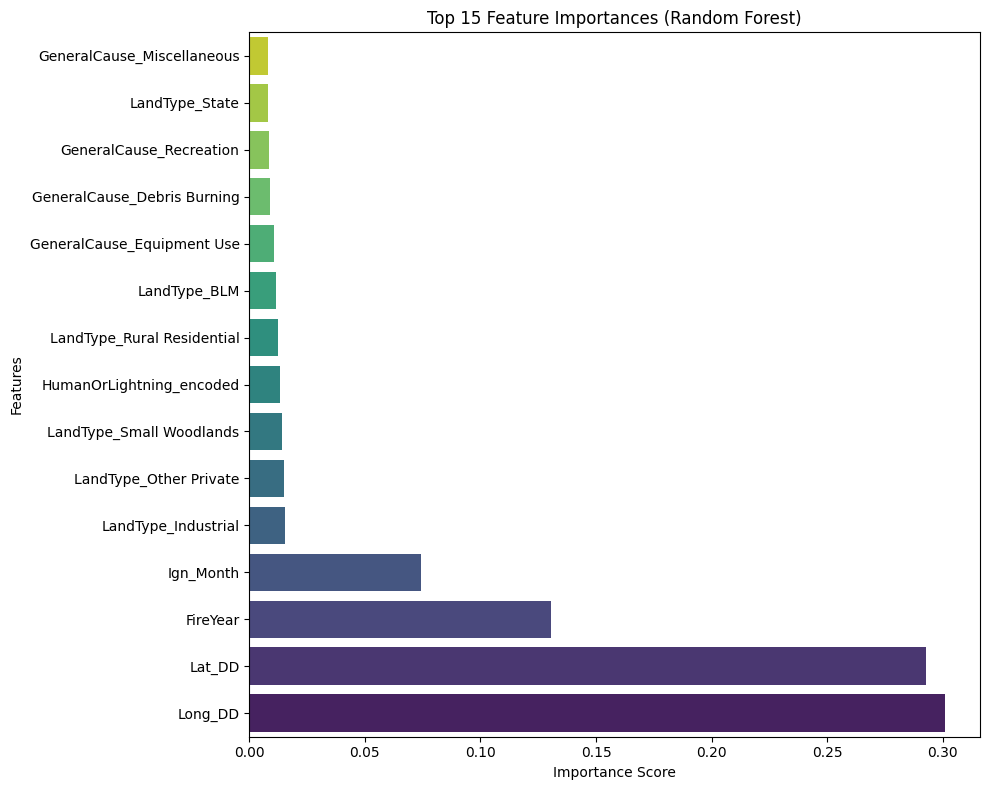

In [ ]:
import seaborn as sns

# Select the top N features to plot
top_n = 15
top_importances = sorted_importances.head(top_n)

# Create the plot
plt.figure(figsize=(10, 8)) # Adjust figure size as needed
sns.barplot(x=top_importances.values, y=top_importances.index, palette='viridis')
plt.title(f'Top {top_n} Feature Importances (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.gca().invert_yaxis() # Display feature with highest importance at the top
plt.tight_layout()
plt.show()

Location and Time dominate feature importance. Together, Long_DD (longitude), Lat_DD (Latitude), Fire Year, and Ing_Month account for the vast majority (~80%) of the model's decision-making power. This suggests that where and when a fire occurs are the most critical factors currently available in the dataset for predicting the fire's size. After these four features, there is a significant drop-off in importance.

It may be beneficial to enhance location features, but given the scope of this project, this is not an avenue we will pursue.

In [ ]:
# check if 'Ign_Month' column exists
if 'Ign_Month' in X_train_over.columns and 'Ign_Month' in X_test_over.columns:

    print("Applying cyclical encoding to 'Ign_Month'...")

    # create copies to avoid modifying original dataframes directly if needed later
    X_train_over_cyclical = X_train_over.copy()
    X_test_over_cyclical = X_test_over.copy()

    # apply Sine transformation
    X_train_over_cyclical['Month_sin'] = np.sin(2 * np.pi * X_train_over_cyclical['Ign_Month']/12)
    X_test_over_cyclical['Month_sin'] = np.sin(2 * np.pi * X_test_over_cyclical['Ign_Month']/12)

    # apply Cosine transformation
    X_train_over_cyclical['Month_cos'] = np.cos(2 * np.pi * X_train_over_cyclical['Ign_Month']/12)
    X_test_over_cyclical['Month_cos'] = np.cos(2 * np.pi * X_test_over_cyclical['Ign_Month']/12)

    # drop the original 'Ign_Month' column
    X_train_over_cyclical = X_train_over_cyclical.drop('Ign_Month', axis=1)
    X_test_over_cyclical = X_test_over_cyclical.drop('Ign_Month', axis=1)

    print("Created 'Month_sin', 'Month_cos' features and dropped 'Ign_Month'.")
    print("New training features shape:", X_train_over_cyclical.shape)
    print("New test features shape:", X_test_over_cyclical.shape)


    # re-train  BEST Random Forest model on modified data
    # replace 'rf_tuned' with the variable holding best RF model object
    best_rf_model_variable = rf_tuned

    print(f"\nRe-training model ({type(best_rf_model_variable).__name__}) on data with cyclical month features...")
    best_rf_model_variable.fit(X_train_over_cyclical, y_train_over)
    print("Re-training complete.")


    # re-evaluate on the modified test set
    print("\nEvaluating model on test set with cyclical month features...")
    y_pred_rf_cyclical = best_rf_model_variable.predict(X_test_over_cyclical)

    mse_rf_cyclical = mean_squared_error(y_test_over, y_pred_rf_cyclical)
    rmse_rf_cyclical = np.sqrt(mse_rf_cyclical)
    r2_rf_cyclical = r2_score(y_test_over, y_pred_rf_cyclical)

    print("\n--- Random Forest with Cyclical Month (Oversampled Data) Test Set Results ---")
    print(f"Mean Squared Error (MSE): {mse_rf_cyclical}")
    print(f"Root Mean Squared Error (RMSE): {rmse_rf_cyclical}")
    print(f"R-squared (R2): {r2_rf_cyclical}")

    # compare with the previous best RF model
    print(f"\nComparison:")
    print(f"  Previous Best RF R2: {r2_rf_tuned:.4f}")
    print(f"  RF R2 with Cyclical Month: {r2_rf_cyclical:.4f}")

else:
    print("Error: 'Ign_Month' column not found in X_train_over or X_test_over DataFrames.")
    print("Please ensure the data preparation steps correctly created this column.")


Applying cyclical encoding to 'Ign_Month'...
Created 'Month_sin', 'Month_cos' features and dropped 'Ign_Month'.
New training features shape: (26232, 46)
New test features shape: (2915, 46)

Re-training model (RandomForestRegressor) on data with cyclical month features...
Re-training complete.

Evaluating model on test set with cyclical month features...

--- Random Forest with Cyclical Month (Oversampled Data) Test Set Results ---
Mean Squared Error (MSE): 0.029899168619191275
Root Mean Squared Error (RMSE): 0.1729137606415154
R-squared (R2): 0.39270201614467537

Comparison:
  Previous Best RF R2: 0.3922
  RF R2 with Cyclical Month: 0.3927


[Source](https://developer.nvidia.com/blog/three-approaches-to-encoding-time-information-as-features-for-ml-models/)

The code block above is cycling encoding. Instead of treating the months as number from 1-12, we made sure to represent the months using sine and cosine transformations so that the months are placed in a circle. This helps the model understand seasonal patterns.

This feature change resulted in a slight increase although not significant. R2 increased from 0.3922 to 0.3927. This suggests the model benefitted from undrestanding the cyclical nature of months. This may reinforce the idea that seasons play a role in the size of small wildfires.

##Error Analysis


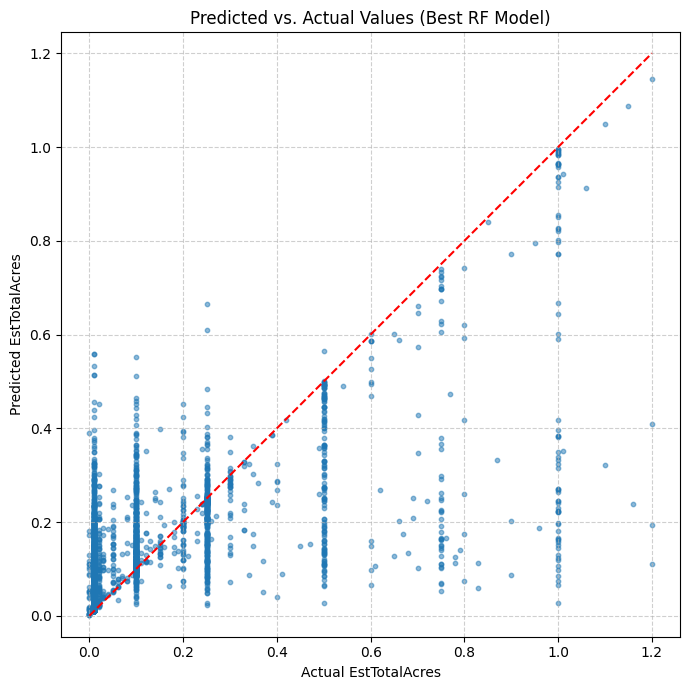

In [ ]:
residuals = y_test_over - y_pred_rf_cyclical
absolute_residuals = np.abs(residuals)


plt.figure(figsize=(7, 7))
plt.scatter(y_test_over, y_pred_rf_cyclical, alpha=0.5, s=10)
max_val = max(y_test_over.max(), y_pred_rf_cyclical.max())
min_val = min(y_test_over.min(), y_pred_rf_cyclical.min())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
plt.title('Predicted vs. Actual Values (Best RF Model)')
plt.xlabel('Actual EstTotalAcres')
plt.ylabel('Predicted EstTotalAcres')
plt.grid(True, linestyle='--', alpha=0.6)
plt.axis('equal')
plt.tight_layout()
plt.show()

The plot visually confirms that while the RF model has learned some patterns related to fire size, it still struggles to make precise predictions. The patterns, vertical bars and performance at extremes highlight the diffuculty in predicting exact fire acreage, especially with the current feature set limitations.

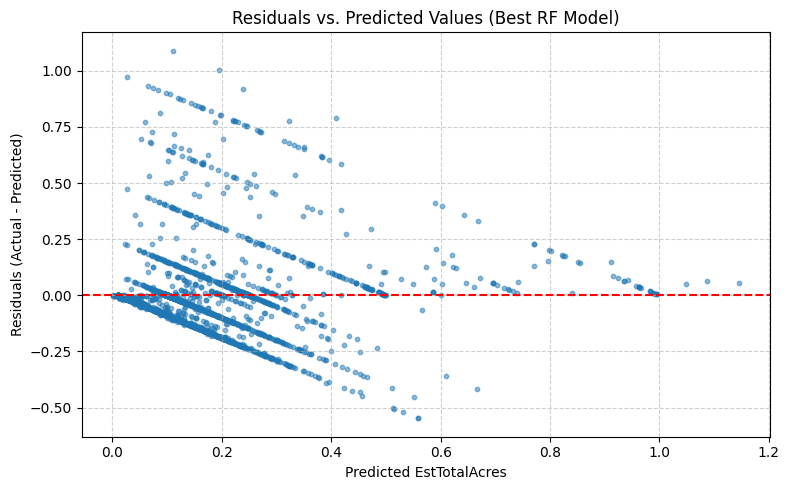

In [ ]:
plt.figure(figsize=(8, 5))
plt.scatter(y_pred_rf_cyclical, residuals, alpha=0.5, s=10)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs. Predicted Values (Best RF Model)')
plt.xlabel('Predicted EstTotalAcres')
plt.ylabel('Residuals (Actual - Predicted)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

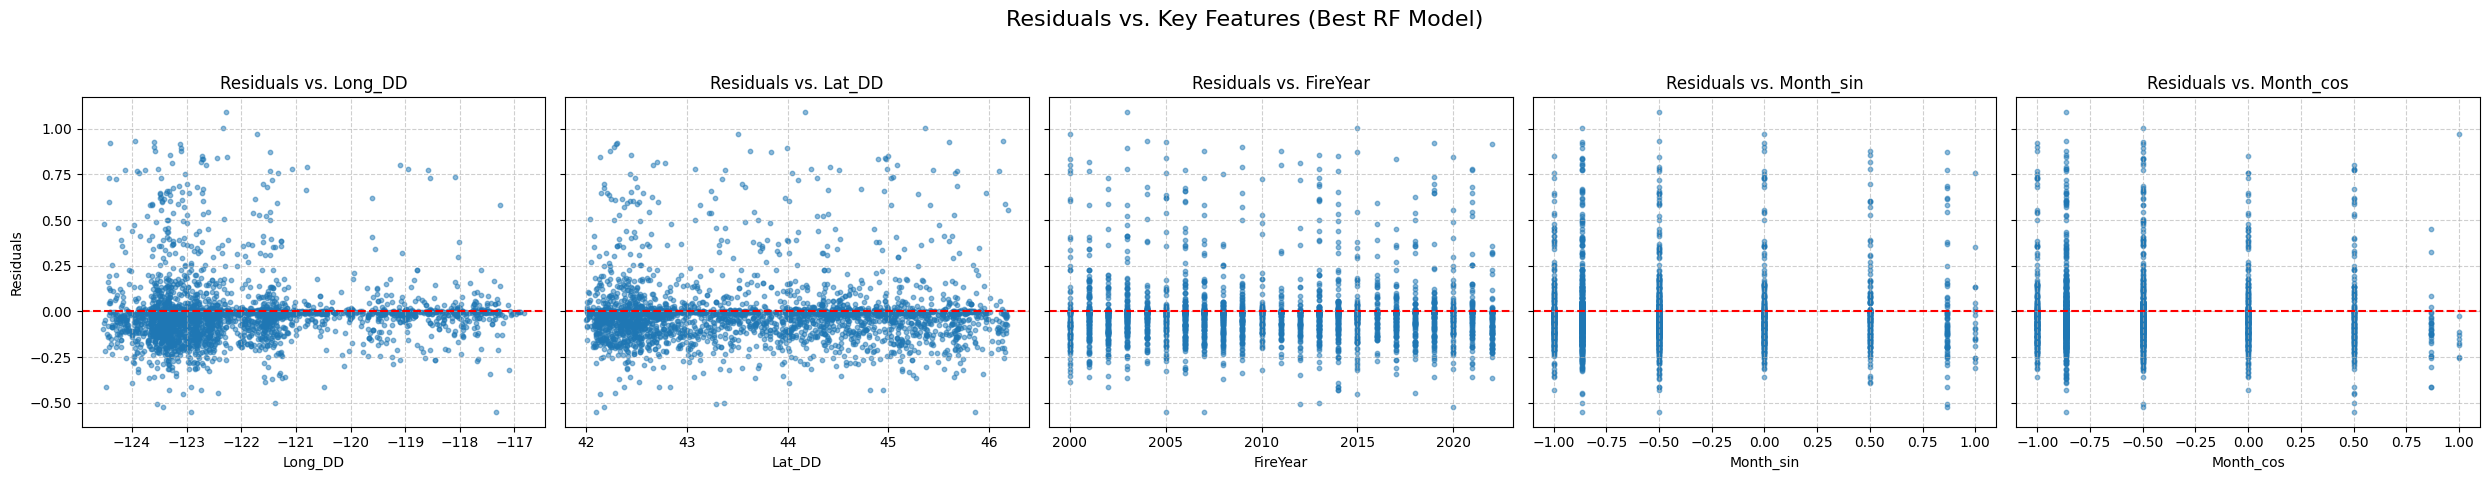

In [ ]:
important_features = ['Long_DD', 'Lat_DD', 'FireYear', 'Month_sin', 'Month_cos'] # Add others if needed

fig, axes = plt.subplots(1, len(important_features), figsize=(5 * len(important_features), 5), sharey=True)
fig.suptitle('Residuals vs. Key Features (Best RF Model)', fontsize=16)

for i, feature in enumerate(important_features):
    if feature in X_test_over_cyclical.columns:
        axes[i].scatter(X_test_over_cyclical[feature], residuals, alpha=0.5, s=10)
        axes[i].axhline(y=0, color='red', linestyle='--')
        axes[i].set_title(f'Residuals vs. {feature}')
        axes[i].set_xlabel(feature)
        if i == 0:
            axes[i].set_ylabel('Residuals')
        axes[i].grid(True, linestyle='--', alpha=0.6)
    else:
        print(f"Warning: Feature '{feature}' not found in X_test_over_cyclical.")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

The plots above show the residuals of the best RF model plotted against the values of the key features. The goal is to see if the errors are systematically related to the values.

There are no obvious trends across all plots. The red line seems to run through the middle of the points fairly consistently across all features.

While the average error isn't trending, the spread of the errors vary slightly across the features, but there isn't an obvious, dramatic fanning pattern tied directly to any single feature. The error variance seems relatively distributed, albeit large overall.

This reinforces the idea the the remaining errors are likely due to more complex interactions between features, inherent randomness or noise in small wildfire spread, or even missing predictive behaviors.

In [ ]:
results_df = X_test_over_cyclical.copy()
results_df['Actual_Acres'] = y_test_over
results_df['Predicted_Acres'] = y_pred_rf_cyclical
results_df['Residual'] = residuals
results_df['Absolute_Residual'] = absolute_residuals

# Sort by absolute residual (largest errors first)
results_df_sorted = results_df.sort_values(by='Absolute_Residual', ascending=False)

# Display the top N instances with the largest errors
n_largest_errors = 20
print(f"\nTop {n_largest_errors} Instances with Largest Prediction Errors:")
print(results_df_sorted.head(n_largest_errors)[['Actual_Acres', 'Predicted_Acres', 'Residual'] + important_features])


Top 20 Instances with Largest Prediction Errors:
       Actual_Acres  Predicted_Acres  Residual    Long_DD    Lat_DD  FireYear  \
28589          1.20         0.110122  1.089878 -122.28616  44.16816      2003   
26106          1.20         0.193995  1.006005 -122.33028  45.36667      2015   
4806           1.00         0.027588  0.972412 -121.71064  43.50645      2000   
16939          1.00         0.065472  0.934528 -123.94015  46.13739      2004   
18393          1.00         0.074398  0.925602 -123.58833  45.59833      2005   
5814           1.16         0.239235  0.920765 -124.40444  42.30861      2019   
19817          1.00         0.083997  0.916003 -123.12169  42.29535      2022   
16965          1.00         0.098692  0.901308 -123.60250  42.27389      2009   
28915          1.00         0.105118  0.894882 -123.09541  43.99492      2003   
13119          1.00         0.119791  0.880209 -123.09361  42.23944      2007   
1736           1.00         0.124042  0.875958 -123.57306  

# SVM - final attempt
SVM has been used in the literature and we will make a final attempt at a model.

In [ ]:
# imports
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

In [ ]:
# scale features
scaler = StandardScaler()

# fit data on training data
scaler.fit(X_train_over_cyclical)

# transform training and test data
X_train_scaled = scaler.transform(X_train_over_cyclical)
X_test_scaled = scaler.transform(X_test_over_cyclical)

# initialization
svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# train
svr.fit(X_train_scaled, y_train_over)

# predict
y_pred_svr = svr.predict(X_test_scaled)

# evaluation
mse_svr = mean_squared_error(y_test_over, y_pred_svr)
rmse_svr = np.sqrt(mse_svr)
r2_svr = r2_score(y_test_over, y_pred_svr)

print("SVR (RBF Kernel, Defaults, Scaled Data) Results:")
print(f"Mean Squared Error (MSE): {mse_svr}")
print(f"Root Mean Squared Error (RMSE): {rmse_svr}")
print(f"R-squared (R2): {r2_svr}")

# comparison
print(f"  Best RF R2: {r2_rf_cyclical:.4f}")
print(f"  SVR R2:     {r2_svr:.4f}")

SVR (RBF Kernel, Defaults, Scaled Data) Results:
Mean Squared Error (MSE): 0.04759206941533876
Root Mean Squared Error (RMSE): 0.21815606664802784
R-squared (R2): 0.03333205777212489
  Best RF R2: 0.3927
  SVR R2:     0.0333


SVR performed very poorly on this task. It is significantly worse that our best RF model with an R2 of 3.3%. It was marginally better than our baseline Linear Regression. This may be telling of the SVRs sensitivity to hyperparameter settings, we used the defaults for this initial test. While hyperparameter tuning may show improvement it does not show promise as the RF model did.


## Hyperparameter Tuning

In [ ]:
# imports
from scipy.stats import reciprocal, uniform

In [ ]:
scaler_svr = StandardScaler()
X_train_scaled = scaler_svr.fit_transform(X_train_over_cyclical)
X_test_scaled = scaler_svr.transform(X_test_over_cyclical)

# parameter options
param_dist_svr = {
    'C': reciprocal(0.1, 1000),
    'gamma': reciprocal(0.0001, 1),
    'epsilon': uniform(loc=0.01, scale=0.2)
}

# set up grid search
svr_base = SVR(kernel='rbf')

random_search_svr = RandomizedSearchCV(
    estimator=svr_base,
    param_distributions=param_dist_svr,
    n_iter=25,  # reduced iterations due to expected slowness
    cv=3,
    scoring='r2',
    verbose=2,
    random_state=2025,
    n_jobs=-1
)

# start search
print("\nStarting Randomized Search CV for SVR...")
random_search_svr.fit(X_train_scaled, y_train_over)
print("Randomized Search CV for SVR complete.")


Starting Randomized Search CV for SVR...
Fitting 3 folds for each of 25 candidates, totalling 75 fits
Randomized Search CV for SVR complete.


In [ ]:
# best parameter selection
best_params_svr = random_search_svr.best_params_
best_score_svr = random_search_svr.best_score_

print(f"\nBest Parameters found by Randomized Search (SVR): {best_params_svr}")
print(f"Best Cross-Validation R2 Score (SVR): {best_score_svr}")

# train final model on best parameters
svr_tuned = SVR(kernel='rbf', **best_params_svr)
svr_tuned.fit(X_train_scaled, y_train_over)

# evaluation
y_pred_svr_tuned = svr_tuned.predict(X_test_scaled)

mse_svr_tuned = mean_squared_error(y_test_over, y_pred_svr_tuned)
rmse_svr_tuned = np.sqrt(mse_svr_tuned)
r2_svr_tuned = r2_score(y_test_over, y_pred_svr_tuned)

print("\nTuned SVR (RBF Kernel, Scaled Data) Test Set Results:")
print(f"Mean Squared Error (MSE): {mse_svr_tuned}")
print(f"Root Mean Squared Error (RMSE): {rmse_svr_tuned}")
print(f"R-squared (R2): {r2_svr_tuned}")

# comparison to best RF model
print(f"  Best RF R2: {r2_rf_cyclical:.4f}")
print(f"  Tuned SVR R2: {r2_svr_tuned:.4f}")


Best Parameters found by Randomized Search (SVR): {'C': np.float64(0.26320758779061204), 'epsilon': np.float64(0.11462954374305628), 'gamma': np.float64(0.03926739448341719)}
Best Cross-Validation R2 Score (SVR): 0.024134969987767946

Tuned SVR (RBF Kernel, Scaled Data) Test Set Results:
Mean Squared Error (MSE): 0.047268887157493875
Root Mean Squared Error (RMSE): 0.21741409144187016
R-squared (R2): 0.039896385232422005
  Best RF R2: 0.3927
  Tuned SVR R2: 0.0399


The hyperparameter tuning of the SVR model provided a small improvement over the default settings. However, it still vastly underperformed compared to the best RF model. This provides strong evidence that SVR with the RBF kernel is not a suitable model for capturing the predictive patterns in this dataset.